# AI model for predicting the electricity prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates
from LSTMmodel import *

%load_ext autoreload
%autoreload 2

In [2]:
# moving to GPU if available (Metal)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


## Loading the data

In [3]:
# path to the CSV file
path = '../../data/fulldata.csv'

data = pd.read_csv(path)

display(data.head())
print(data.shape)

,SpotPriceDKK,from,to,temp_pca_1,temp_pca_2,temp_pca_3,wind_speed_pca_1,wind_speed_pca_2,wind_speed_pca_3,wind_speed_pca_4,...,mean_wind_dir_pca_39,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,oil_price,gas_price,constant
0,596.570007,2024-11-29 23:00:00+00:00,2024-11-30 00:00:00+00:00,-33.480249,7.339981,1.718044,3.248249,2.159318,0.612078,3.505092,...,-0.093112,-0.258819,0.965926,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
1,770.270020,2024-11-29 22:00:00+00:00,2024-11-29 23:00:00+00:00,-32.131543,8.173021,2.038769,2.387323,3.215623,0.288633,3.701821,...,-0.004524,-0.500000,0.866025,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
2,848.200012,2024-11-29 21:00:00+00:00,2024-11-29 22:00:00+00:00,-30.659681,8.780246,1.967827,1.620036,2.482432,0.516816,3.950176,...,-0.081036,-0.707107,0.707107,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
3,836.049988,2024-11-29 20:00:00+00:00,2024-11-29 21:00:00+00:00,-29.321284,9.297498,1.494915,1.490229,2.968878,1.071656,3.674438,...,-0.073105,-0.866025,0.500000,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
4,894.219971,2024-11-29 19:00:00+00:00,2024-11-29 20:00:00+00:00,-27.818541,9.207599,0.853380,2.309477,2.890789,0.990981,2.872615,...,-0.040381,-0.965926,0.258819,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1


(62280, 68)


## Day-ahead predictions

In [4]:
# drop all columns except for the SpotPriceDKK and from
data = data[['SpotPriceDKK', 'from']]

# using the day before as the day-ahead forecast
data['SpotPriceDKK_pred'] = data['SpotPriceDKK'].shift(24)

data = data.dropna()

# filter to relevant period
data = data[data['from'] >= '2024-08-01']

In [5]:
# calculating RMSE and MAE for the naive forecast
rmse_naive = root_mean_squared_error(data['SpotPriceDKK'], data['SpotPriceDKK_pred'])
mae_naive = mean_absolute_error(data['SpotPriceDKK'], data['SpotPriceDKK_pred'])

print(f'RMSE naive: {rmse_naive}')
print(f'MAE naive: {mae_naive}')


RMSE naive: 355.1427542973217
MAE naive: 255.08687936388887


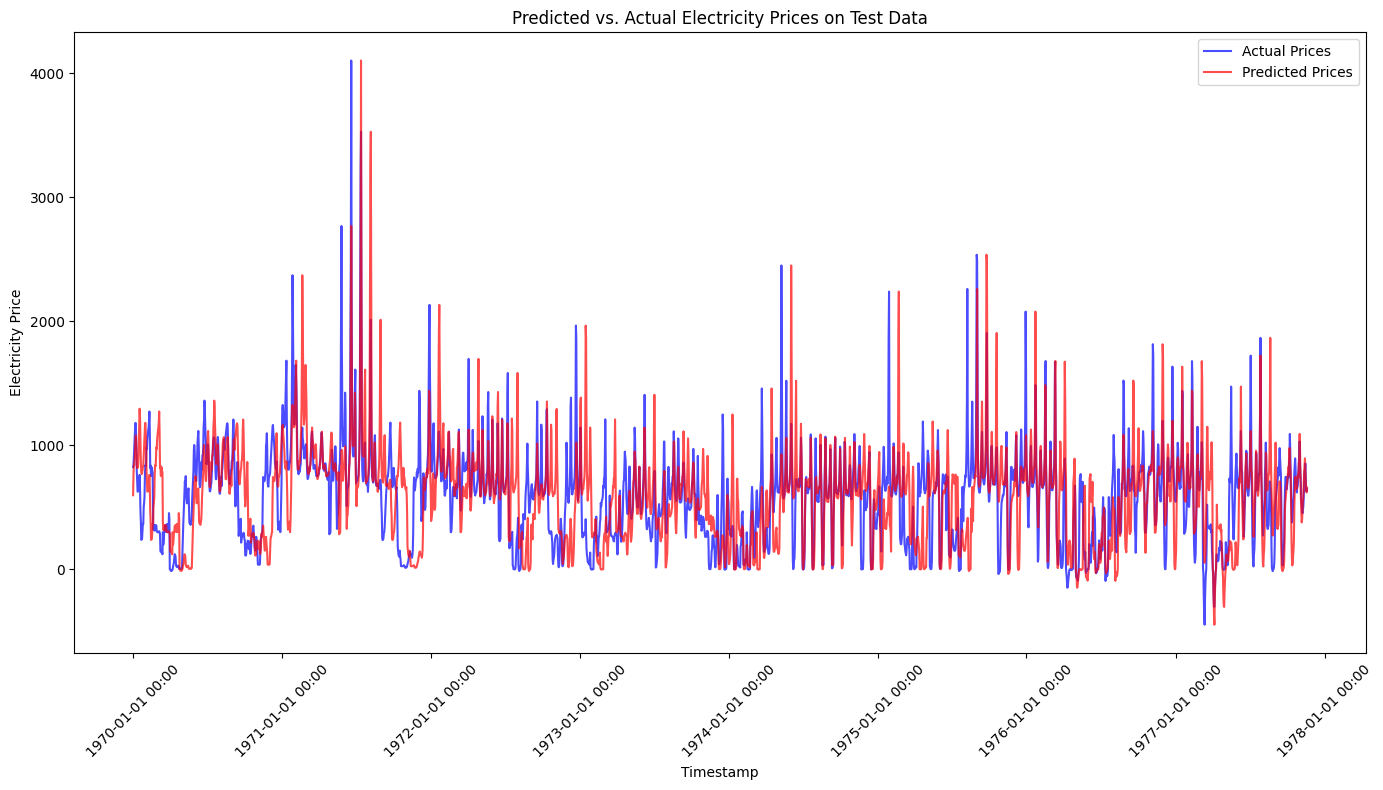

In [6]:
# plotting the naive forecast
predictions = data['SpotPriceDKK_pred'].values
actuals = data['SpotPriceDKK'].values

# create the plot
plt.figure(figsize=(14, 8))
plt.plot(data['from'], actuals, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(data['from'], predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title('Predicted vs. Actual Electricity Prices on Test Data')

# format x-axis with date labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('output/nn-paths/naive_predicted_v_actuals.png')

plt.show()
plt.close()